# Logistic Regression

Tudor Berariu, Andrei Nica, 2018

In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

FIG_SIZE=(12,8)

## Two datasets

In [2]:
def two_clusters(N, variance=0.1):
    N1 = N // 2
    N2 = N - N1
    X1 = np.random.randn(N1, 2) * variance + 0.25
    X2 = np.random.randn(N2, 2) * variance + 0.75
    X = np.concatenate([X1, X2], axis=0)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

def two_rings(N, separation=0.1, noise=0.2):
    N1 = N // 2
    N2 = N - N1
    angles = np.random.rand(N, 1) * 2 * np.pi
    radius = np.random.rand(N, 1) + np.random.randn(N, 1) * noise
    radius *= .5 - separation / 2
    radius[N2:] += .5 + separation / 2
    X = np.concatenate([radius * np.sin(angles), radius * np.cos(angles)], axis=1)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

In [3]:
def visualize_dataset(X, T, Y=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(figsize=FIG_SIZE); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    return fig.axes[0]

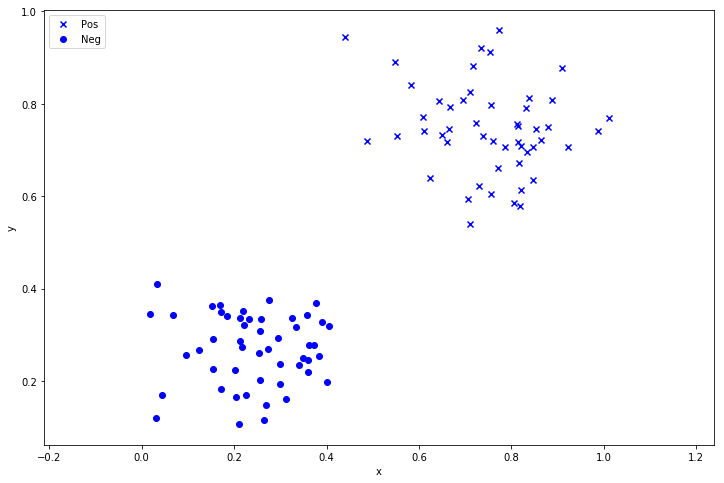

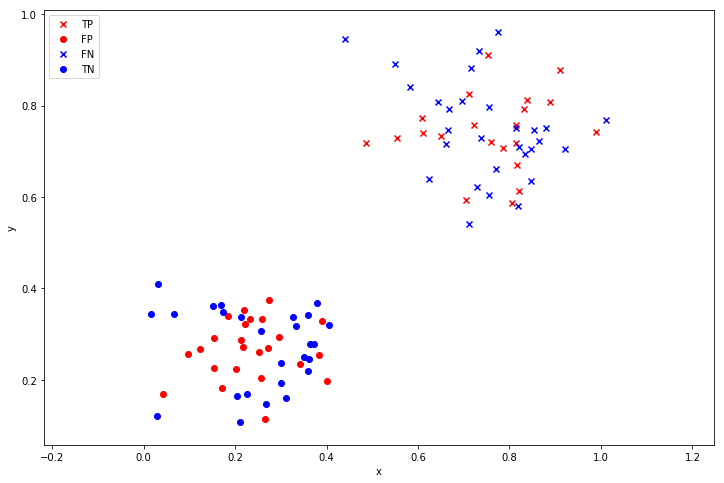

In [4]:
X, T = two_clusters(100, variance=0.1)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

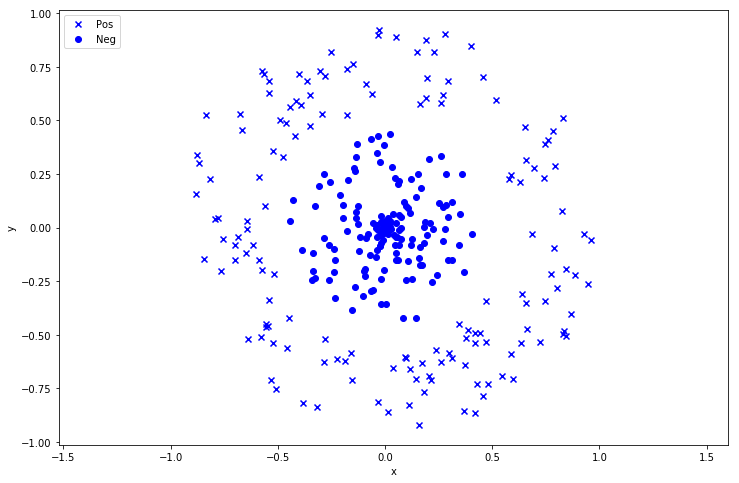

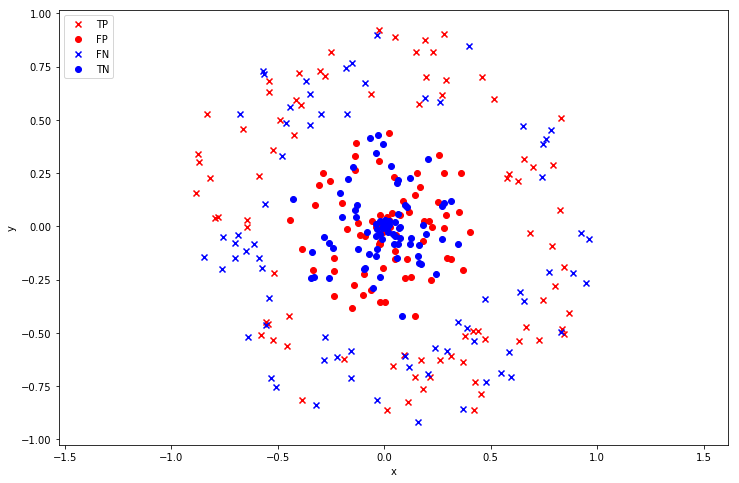

In [5]:
X, T = two_rings(300, noise=0.01)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

## Using linear regression for classification?

We'll use the following convention: ${\bf w}^{\text{T}}{\bf x} + b = 1$ for positive examples and ${\bf w}^{\text{T}}{\bf x} +b = 0$ for negative examples.

Actually: $\hat{x} = [x_0, x_1, 1]$ and $y = {\bf w}^{\text{T}}\hat{{\bf x}}$

In [6]:
def train_linear(X, T):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.dot(np.linalg.pinv(X_hat), T)
    return W

In [7]:
def predict_linear(X, W):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = np.dot(X_hat, W)
    return Y

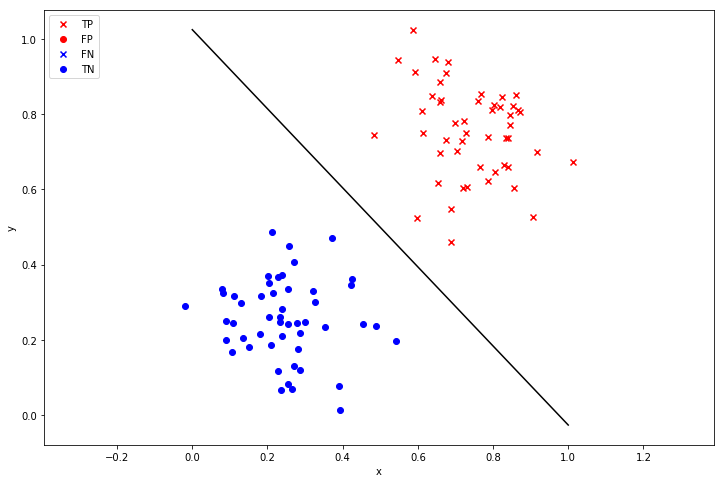

In [8]:
X, T = two_clusters(100, variance=0.1)
W = train_linear(X, T)
Y = predict_linear(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

### How about adding some other examples that should pose no problems?

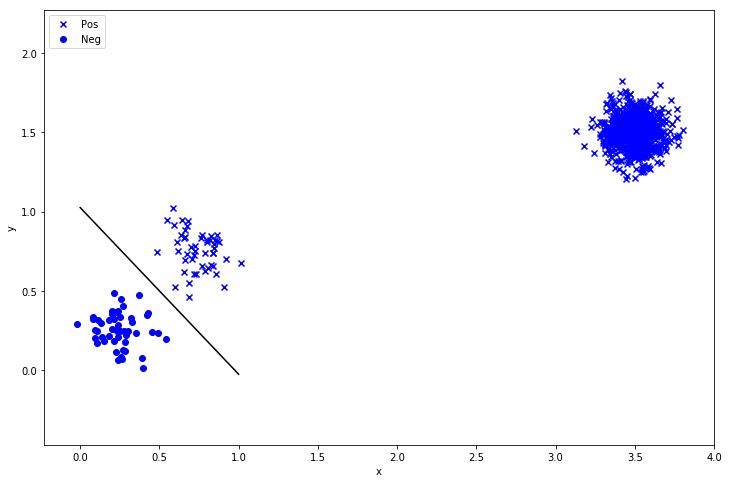

In [16]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

### Let's train the model on full data

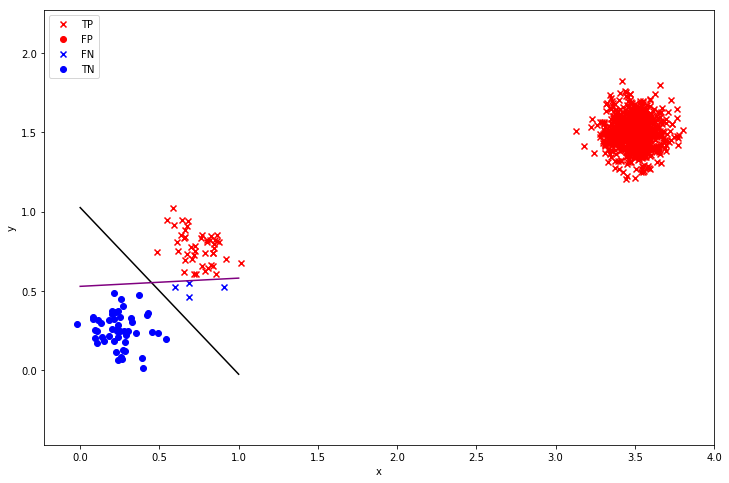

In [19]:
W_full = train_linear(X_full, T_full)
Y = predict_linear(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (.5 - __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)


plt.show()

## The logistic function

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$


In [22]:
def logistic(x):
    return 1. / (1. + np.exp(-x))

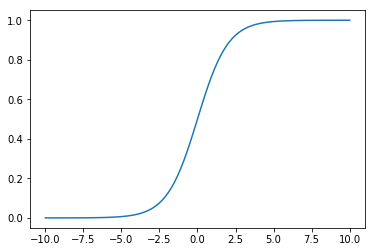

In [25]:
x = np.linspace(-10, 10, 100)
plt.plot(x, logistic(x))